In [1]:
%matplotlib inline

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


Load data

In [178]:
with gzip.open('mnist.pkl.gz') as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

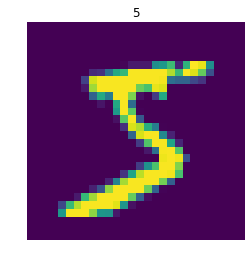

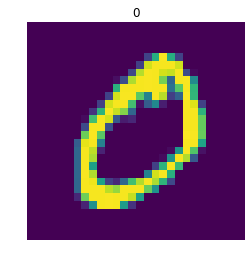

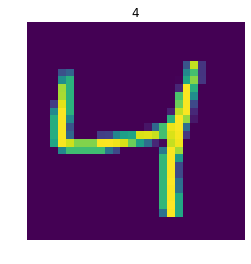

In [3]:
# plot some examples
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)))
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

Convolutional Layer

In [4]:
def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(conv.output_shape.size, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("LAYER")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv

In [169]:
def dense_layer(x, shape, activation=True, next_shape=1):
    # create a Conv2D transform with the given arguments
    #dense = nengo.Convolution(*args, channels_last=False, **kwargs)
    #print(x.size_out)
    dense = nengo.Dense( shape, init=np.ones((x.size_out,1)) )

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(next_shape, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=dense.size_out)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=np.ones((next_shape,dense.size_out)) )

    # print out the shape information for our new layer
    print("LAYER")
    print(dense.size_out, "->", dense.size_out)

    return layer, dense

Model

In [78]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    #nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28 )

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=28 * 28)
    #out = nengo.Node(size_in=10)

    # build parallel copies of the network
    for _ in range(n_parallel):
        layer, conv = conv_layer(
            inp, 1, input_shape, kernel_size=(1, 1),
            init=np.ones((1, 1, 1, 1)))
        # first layer is off-chip to translate the images into spikes
        #net.config[layer.ensemble].on_chip = False
        encoded, conv = conv_layer(layer, 6, conv.output_shape,
                                 strides=(2, 2))
        decoded, conv = conv_layer(encoded, 1, conv.output_shape,
                                 strides=(2, 2), padding='same')
        nengo.Connection(decoded, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (1, 7, 7)
LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (1, 7, 7)


In [81]:
np.asarray(inp).shape

(784,)

In [56]:
np.asarray(conv.output_shape)

array(ChannelShape(shape=(1, 7, 7), channels_last=False), dtype=object)

In [171]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    #nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28 )

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=28 * 28)
    #out = nengo.Node(size_in=10)

    print(np.asarray(inp).shape)
    # build parallel copies of the network
    for _ in range(n_parallel):
        #layer, dense = dense_layer(inp, (784,1) )
        # first layer is off-chip to translate the images into spikes
        #net.config[layer.ensemble].on_chip = False
        encoded, dense = dense_layer(layer, (784,1), next_shape=32)
        encoded, dense = dense_layer(encoded, (32,1), next_shape=784)
        decoded, dense = dense_layer(encoded, (784,1),next_shape=784)
        nengo.Connection(decoded, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

(784,)
LAYER
784 -> 784
LAYER
32 -> 32
LAYER
784 -> 784
LAYER
784 -> 784
LAYER
32 -> 32
LAYER
784 -> 784


In [179]:
# set up training data
minibatch_size = 200
train_data = {inp: train_data[0][:, None, :],
              out_p: train_data[1][:, None, :]}

# for the test data evaluation we'll be running the network over time
# using spiking neurons, so we need to repeat the input/target data
# for a number of timesteps (based on the presentation_time)
test_data = train_data
#test_data = {inp: train_data[0][:, None, :],
#              out_p: train_data[1][:, None, :]}

In [174]:
def crossentropy(outputs, targets):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets))


def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))

In [175]:
## import requests module
try:
    import requests
    has_requests = True
except ImportError:
    has_requests = False

In [180]:
do_training = True #False

with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    if do_training:
        print("error before training: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

        # run training
        sim.train(train_data, tf.train.RMSPropOptimizer(learning_rate=0.001),
                  objective={out_p: crossentropy}, n_epochs=5)

        print("error after training: %.2f%%" %
              sim.loss(test_data, {out_p_filt: classification_error}))

        sim.save_params("./mnist_params")
    else:
        download("mnist_params.data-00000-of-00001",
                 "1BaNU7Er_Q3SJt4i4Eqbv1Ln_TkmmCXvy")
        download("mnist_params.index", "1w8GNylkamI-3yHfSe_L1-dBtvaQYjNlC")
        download("mnist_params.meta", "1JiaoxIqmRupT4reQ5BrstuILQeHNffrX")
        sim.load_params("./mnist_params")

    # store trained parameters back into the network
    sim.freeze_params(net)

Build finished in 0:00:00                                                      


BuildError: Building <Connection from <Neurons of <Ensemble (unlabeled) at 0x7f92ee166470>> to <Neurons of <Ensemble (unlabeled) at 0x7f92d7f59ba8>>>: the 'pre' object <Neurons of <Ensemble (unlabeled) at 0x7f92ee166470>> is not in the model, or has a size of zero.

-----------------

1D signal model

In [106]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot


def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders

In [104]:
model = nengo.Network(label="NEF summary")
presentation_time = 0.1
with model:
    input = nengo.Node(nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)
    input_probe = nengo.Probe(input)

In [112]:
intercepts, encoders = aligned(10)  # Makes evenly spaced intercepts
with model:
    A = nengo.Ensemble(
        10,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(80, 100),
        encoders=encoders)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

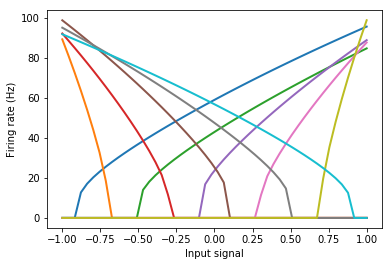

In [108]:
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(A, sim)

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");
hide_input()

In [113]:
with model:
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons)

ValidationError: init: Shape of initial value () does not match expected shape (1, 784)

In [151]:
model= nengo.Network(seed=0)
#model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(nengo.processes.PresentInput(test_data[0], presentation_time),
        size_out=28 * 28)
    input_probe = nengo.Probe(input)
    A = nengo.Ensemble(30, dimensions=1, max_rates=nengo.dists.Choice([max_rate]) )
    nengo.Connection(input, A, transform=np.ones((1,784)))
    A_spikes = nengo.Probe(A.neurons)
    A_probe = nengo.Probe(A, synapse=0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

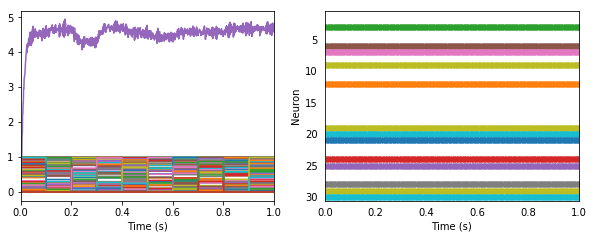

In [149]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded esimate")
#plt.legend(loc="best")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
plt.show()